**INSTALL & IMPORT LIBRARY**

In [1]:
!pip install google-play-scraper Sastrawi scikit-learn wordcloud


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt

from google_play_scraper import reviews, Sort

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

from wordcloud import WordCloud


**DATA ACQUISITION**

In [3]:
result, continuation_token = reviews(
    'com.whatsapp',
    lang='id',
    country='id',
    sort=Sort.NEWEST,
    count=1000
)

df = pd.DataFrame(result)
df = df[['userName','content', 'score', 'at']]
df.head()


,userName,content,score,at
0,Sugi Anto,Sku suka banget Ok,5,2025-12-24 08:12:50
1,Septiyan Vandi,mohon diperbaiki semisal penyimpanan hp kita p...,1,2025-12-24 08:12:01
2,bayu ajah,aplik yg g😭 nhnbhbnbjhnnnhnhrnbb mnjm m m tggu...,2,2025-12-24 08:09:48
3,Fatmah Fatmah,Saya sangat puas dengan pelayanan nya,5,2025-12-24 08:08:21
4,Adrianus Dendi,Mantap,5,2025-12-24 08:05:16


**SIMPAN DATASET**

In [5]:
df.to_csv("ulasan_whatsapp_playstore.csv", index=False)


**LABELING SENTIMEN**

In [6]:
def label_sentiment(score):
    if score >= 4:
        return 'positif'
    elif score == 3:
        return 'netral'
    else:
        return 'negatif'

df['sentiment'] = df['score'].apply(label_sentiment)


**PREPROCESSING TEKS**

In [7]:
#Inisialisasi
stemmer = StemmerFactory().create_stemmer()
stopwords = set(StopWordRemoverFactory().get_stop_words())

#Fungsi preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [word for word in text.split() if word not in stopwords]
    return stemmer.stem(" ".join(tokens))

#Jalankan preprocessing
df['clean_text'] = df['content'].apply(preprocess_text)
df['review_length'] = df['content'].str.len()



**EXPLORATORY DATA ANALYSIS (EDA)**

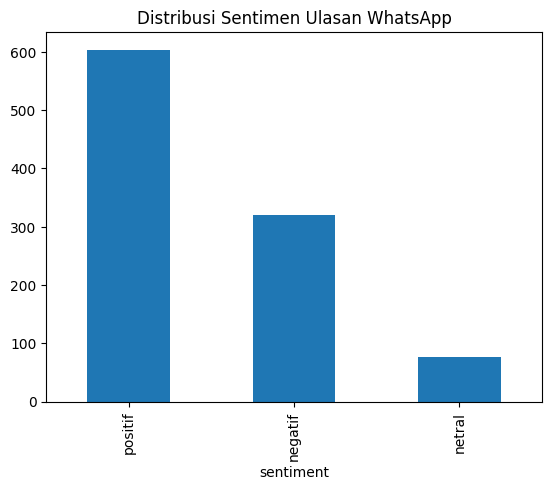

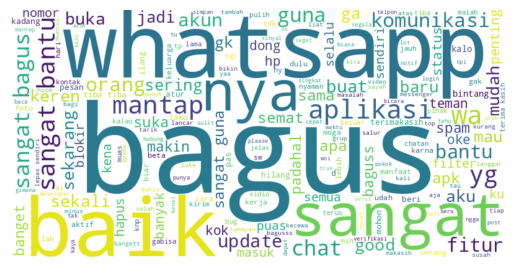

In [8]:
#Distribusi Sentimen
df['sentiment'].value_counts().plot(kind='bar')
plt.title("Distribusi Sentimen Ulasan WhatsApp")
plt.show()

#WordCloud Sentimen Positif
neg_text = " ".join(df[df['sentiment'] == 'positif']['clean_text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neg_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


**FEATURE EXTRACTION (TF-IDF)**

In [9]:
X = df['clean_text']
y = df['sentiment']

vectorizer = TfidfVectorizer(max_features=3000)
X_tfidf = vectorizer.fit_transform(X)


**SPLIT DATA**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)


**MODELING**




In [11]:
#Model Naive Baiyes
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred_nb = model.predict(X_test)


#Model Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)



**EVALUASI MODEL**

In [12]:

#Evaluasi Logistic Regression
print("================ LOGISTIC REGRESSION ================ ")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))
print("-----------------------------------------------------")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("-----------------------------------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
#Evaluasi Naive Bayes
y_pred = model.predict(X_test)

print("==================== NAIVE BAYES ==================== ")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("-----------------------------------------------------")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("-----------------------------------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("=====================================================")


================ LOGISTIC REGRESSION ================ 

Classification Report:
               precision    recall  f1-score   support

     negatif       0.68      0.50      0.58        64
      netral       0.00      0.00      0.00        14
     positif       0.75      0.93      0.83       122

    accuracy                           0.73       200
   macro avg       0.48      0.48      0.47       200
weighted avg       0.67      0.73      0.69       200

-----------------------------------------------------

Confusion Matrix:
 [[ 32   0  32]
 [  7   0   7]
 [  8   0 114]]
-----------------------------------------------------
Accuracy: 0.73
==================== NAIVE BAYES ==================== 

Classification Report:
               precision    recall  f1-score   support

     negatif       0.73      0.58      0.64        64
      netral       0.00      0.00      0.00        14
     positif       0.77      0.94      0.85       122

    accuracy                           0.76       20

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

**TABEL PERBANDINGAN MODEL**

In [13]:
from sklearn.metrics import precision_recall_fscore_support

nb_metrics = precision_recall_fscore_support(y_test, y_pred_nb, average='weighted')
lr_metrics = precision_recall_fscore_support(y_test, y_pred_lr, average='weighted')

comparison_full = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression'],
    'Precision': [nb_metrics[0], lr_metrics[0]],
    'Recall': [nb_metrics[1], lr_metrics[1]],
    'F1-Score': [nb_metrics[2], lr_metrics[2]],
    'Accuracy': [
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_lr)
    ]
})

comparison_full


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Precision,Recall,F1-Score,Accuracy
0,Naive Bayes,0.702962,0.76,0.723625,0.76
1,Logistic Regression,0.672382,0.73,0.690250,0.73


**SIMPAN MODEL**

In [14]:
df.to_csv("dataset_final_whatsapp_sentiment.csv", index=False)
